In [1]:
import sys
sys.path.append('../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_forward, run_rc_sim, UniformPrior, linear_scale_array,
                   get_dataset_psd, get_dataset_peaks, load_posterior)
import dill
from sbi import utils as sbi_utils
import pandas as pd
from scipy.stats import wasserstein_distance

sns.set()
sns.set_style("white")

device = 'cpu'
data_path = '../data/rc_circuit'

with open(f'{data_path}/posteriors/rc_posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/rc_posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation

t_vec = np.linspace(0, tstop, np.round(tstop/dt).astype(int))

### Load posterior

In [2]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
x_cond, theta_cond = np.load(f'{data_path}/sbi_sims/x_grid.npy'), np.load(f'{data_path}/sbi_sims/theta_grid.npy')

x_orig_peak = get_dataset_peaks(x_orig)
x_cond_peak = get_dataset_peaks(x_cond)


fs = posterior_metadata['fs'] # Frequency defined for PSD
x_orig_psd, f = get_dataset_psd(x_orig, fs=fs)
x_cond_psd, f = get_dataset_psd(x_cond, fs=fs)

load_info = {'raw_waveform_noise': {'x_train': x_orig, 'x_cond': x_cond},
                   'peak_noise': {'x_train': x_orig_peak, 'x_cond': x_cond_peak},
                   'psd_noise': {'x_train': x_orig_psd, 'x_cond': x_cond_psd}}

posterior_names = list(posterior_state_dicts.keys())
print(posterior_names)

['rc_raw_waveform_noise', 'rc_peak_noise', 'rc_psd_noise']


In [3]:
name_idx = 2 # Pick posterior to load

name = posterior_names[name_idx]
posterior_dict = posterior_state_dicts[name]
state_dict = posterior_dict['posterior']
n_params = posterior_dict['n_params']
input_type = posterior_dict['input_type']
n_sims = posterior_dict['n_sims']
input_dict = posterior_dict['input_dict']

embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])

posterior = load_posterior(state_dict=state_dict,
                           x_infer=torch.tensor(load_info[input_type]['x_train'][:10,:]).float(),
                           theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

### Calculate wasserstein distance for each location on the grid

In [ ]:
dist_list = list()
for cond_idx in range(x_cond.shape[0]):
    if cond_idx % 100 == 0:    
        print(cond_idx, end=' ')
    samples = posterior.sample((100,), x=load_info[input_type]['x_cond'][cond_idx,:])

    dist = [wasserstein_distance(samples[:,param_idx], [theta_cond[cond_idx,param_idx]]) for
            param_idx in range(samples.shape[1])]
    
    dist_list.append(dist)

In [29]:
#dist_array = np.array(dist_list)
#np.save(f'{data_path}/posteriors/{input_type}_wasserstein_grid.npy', dist_array)


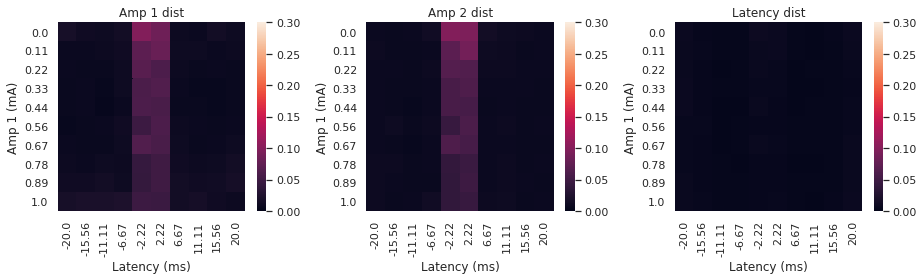

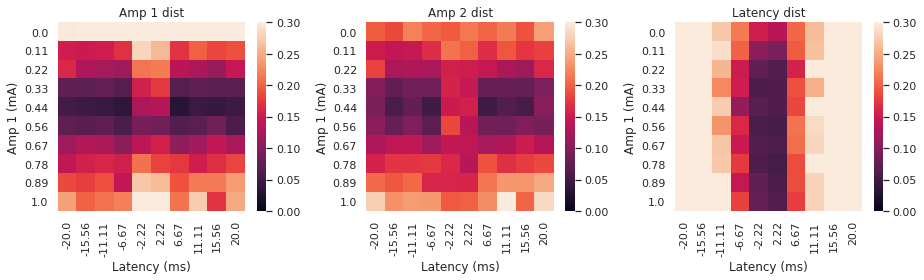

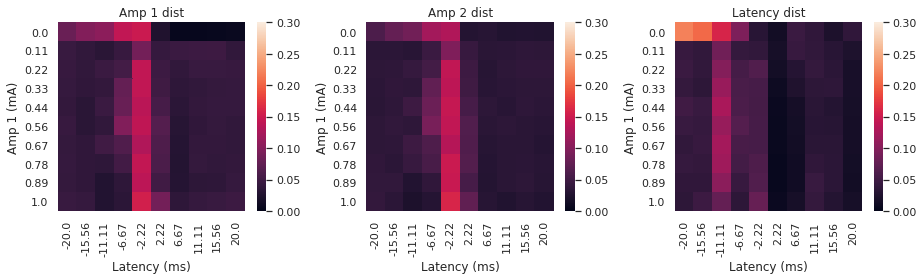

In [34]:
%matplotlib inline
input_type_list = ['raw_waveform_noise', 'psd_noise', 'peak_noise']
plot_labels = ['Amp 1 dist', 'Amp 2 dist', 'Latency dist']
param_labels = ['Amp 1 (mA)', 'Amp 2 (mA)', 'Latency (ms)']
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

for input_type in input_type_list:
    dist_array = np.load(f'{data_path}/posteriors/{input_type}_wasserstein_grid.npy')
    plt.figure(figsize=(13,4))
    for plot_idx in range(3):
        plt.subplot(1,3,plot_idx+1)
        xticks = np.round(np.linspace(all_bounds[2][0], all_bounds[2][1], 10), decimals=2)
        yticks = np.round(np.linspace(all_bounds[0][0], all_bounds[0][1], 10), decimals=2)
        sns.heatmap(dist_array[:,plot_idx].reshape(10,10,10)[:,5,:], vmin=0, vmax=0.3,
                    xticklabels=xticks, yticklabels=yticks)
        plt.title(plot_labels[plot_idx])
        plt.xlabel(param_labels[2])
        plt.ylabel(param_labels[0])
    plt.tight_layout()
